# PRF model fitting

## Goals

1. Fit some prf models to the merged data.
2. Do some plotting.
3. Export a nifti with the prf params.

## Component 1 - The data.

In [1]:
MERGED_DATA='/media/nicholas/STORE/merge.nii.gz'

These data are pre-processed and averaged across runs. The data are expressed in percent signal change. 

In [2]:
import nibabel as nb

img = nb.load(MERGED_DATA)
data = img.get_data()

In [3]:
data.shape

(97, 115, 97, 120)

In [4]:
import matplotlib.pyplot as plt

I want to plot some example data. 

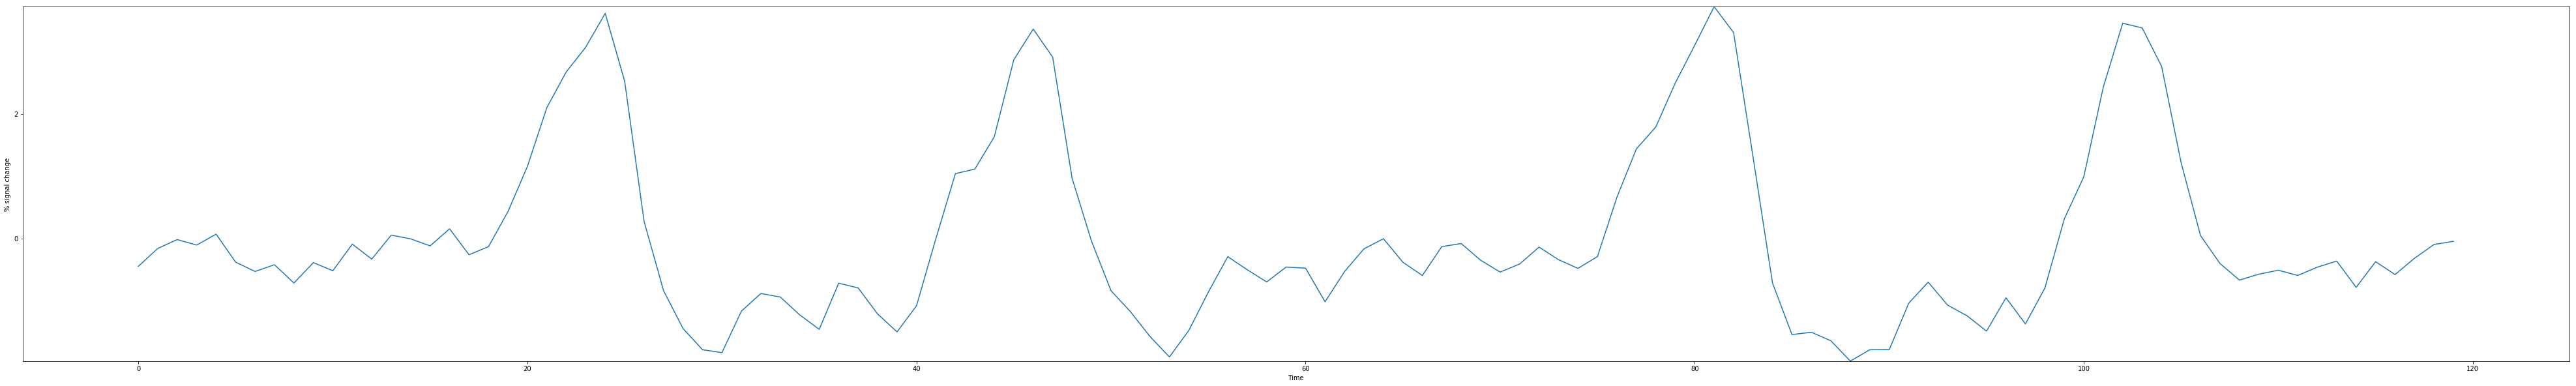

In [5]:
import numpy as np

figsizex=70
figsizey=10

def plotts(data):
    ylim=(np.min(data),np.max(data))
    plt.figure(figsize=(figsizex,figsizey))
    plt.plot(data)
    plt.rcParams.update({'font.size': 80})
    plt.ylim(ylim)
    plt.xlabel('Time')
    plt.ylabel('% signal change')
    plt.show()
    

plotts(data[58,24,35,:])


It's...... beautiful.

Now lets import the stimulus

## Component 2 - The stimulus.

In [7]:
stimdir='/media/nicholas/STORE/Tomasdat/stim_tomas'

dm = np.load(stimdir+'/design_matrix.npy')

# put time dimension last for popeye
dm = np.moveaxis(dm,0,2)

# binarize
dm[dm<0.5] = 0
dm[dm>0.5] = 1

# remove fixation point
dm[49,88,:] = 0
dm[49,89,:] = 0
dm[50,88,:] = 0
dm[50,89,:] = 0

#revert y axis
dm = dm[::-1,:,:] # this is how popeye wants y dim (0 point is top of dm)


In [8]:
dm.shape
N_TIMEPOINTS = np.shape(dm)[2]
N_TIMEPOINTS

119

Do a bit of plotting to get some sense of the behavior of the bar.

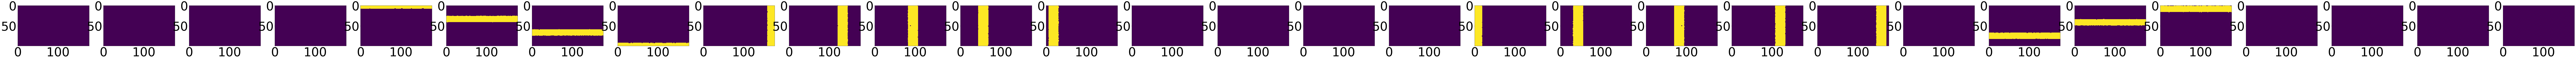

In [9]:
def plotbarsweep(bar,sweepnum,steps,nsamps):
    startpoint=(sweepnum*steps)
    plt.subplots(figsize=((nsamps*10), 10))
    samps=np.floor(np.linspace(startpoint,(startpoint+steps)-1,nsamps))
    x=(np.floor(samps))
    x2=x.astype(int)
    for i in range(len(x2)):
        plt.subplot(1,nsamps,i+1)
        plt.imshow(bar[:,:,(x2[i])])


plotbarsweep(dm,0,119,30)

The behavior is thus: blank, down, left, blank, right, up, blank.

## Component 3 - The model.

To keep the complexity low, I want to use a standard gaussian model. 

In [10]:
import ctypes, multiprocessing
import numpy as np
import sharedmem
import popeye.og_hrf as og
import popeye.utilities as utils
from popeye.visual_stimulus import VisualStimulus


TR = 1.5

stimulus = VisualStimulus(stim_arr = dm,viewing_distance = 225, screen_width =  69.84,scale_factor = 1,
                          tr_length = TR,
                          dtype = np.short)

model = og.GaussianModel(stimulus, utils.double_gamma_hrf)

Now define some grids and bounds. I am copying the relevant ones from Dan's code

In [13]:
grid_size = 4 

# X location grid
x_grid = (-10,10)

# Y location grid
y_grid = (-5,5)

# SD location grid. Here the minimum is set to 1 pixel. 
s_grid = (1/stimulus.ppd,10)

# This would seem to have to be the beta parameter?
b_grid = (0.1,1.0)

# This would seem to baseline parameter? (or alternatively hrf delay)
h_grid = (-1.0,1.0)


x_bound = (-50,50)

y_bound = (-50,50)

s_bound = (0.001, 10)

b_bound = (1e-8,None)

u_bound = (None,None)

h_bound = (-3.0,3.0)

## package the grids and bounds
grids = (x_grid, y_grid, s_grid, h_grid)

bounds = (x_bound, y_bound, s_bound, h_bound, b_bound, u_bound)


A few things worth commenting on here.


1. I don't quite understand why the bounds seem to extend so far beyond the range of the monitor (-50, 50)?
2. Since we have normalised the data into percet signal change, can we not keep the baseline parameter fixed?

## Test fit.

I am going to fit a model to that nice looking voxel that I plotted earlier.

In [11]:
testdat=data[58,24,35,:N_TIMEPOINTS]

In [14]:
fit = og.GaussianFit(model,testdat, grids, bounds, Ns=grid_size, voxel_index=(1,2,3), auto_fit=True,verbose=1)

VOXEL=(001,002,003)   TIME=007   RSQ=0.87  EST=[1.9907 2.6663 1.2907 0.0172 0.0051 0.0004]


That is quite a respectable R2. Now plot the model fit alongside the bar for visualisation purposes

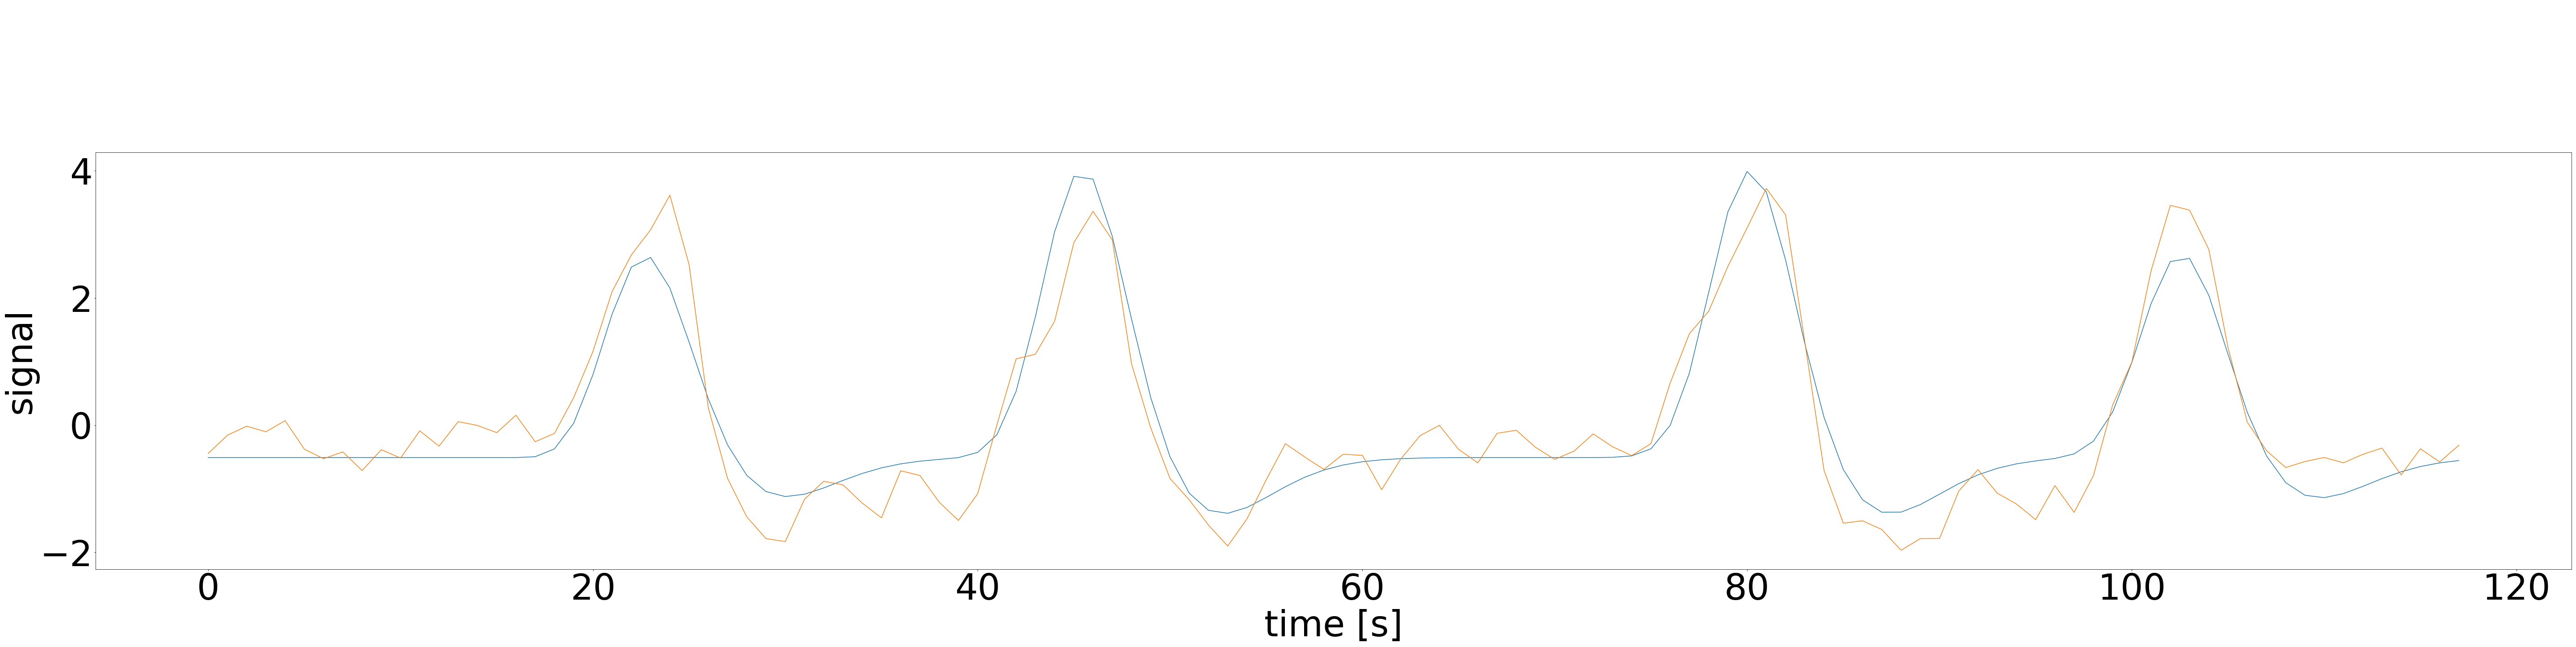

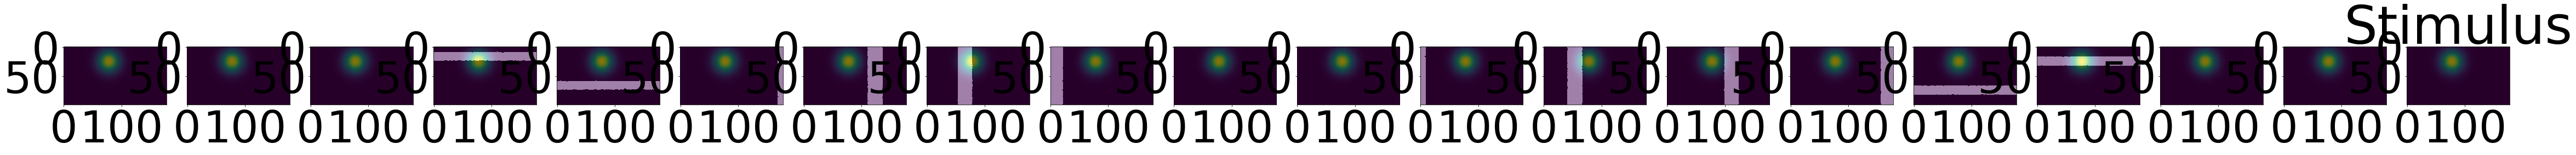

In [15]:
def plotbar(bar,fit,nsamps,idxmin,idxmax):
    plt.subplots(figsize=((nsamps*4), 20))
    
    if not idxmin:
        idxmin=0
        idxmax=(bar.shape[2]-1)
    samps=np.floor(np.linspace(idxmin,idxmax,nsamps))
    x=(np.floor(samps))
    x2=x.astype(int)
    for i in range(len(x2)):
        plt.subplot(1,nsamps,i+1)
        plt.imshow(fit.receptive_field) 
        plt.imshow(bar[:,:,(x2[i])], cmap='hot', alpha=0.5)



def plotprfpred(fit,bar,nsamps,idxmin,idxmax):

    import matplotlib.mlab as mlab
    import matplotlib.gridspec as gridspec
    fig = plt.figure(constrained_layout=True,figsize=((nsamps*4), 20))
    gs = gridspec.GridSpec(4,nsamps, figure=fig)
    
    if not idxmin:
        idxmin=0
        idxmax=(len(fit.data)-1)

    ax1 = fig.add_subplot(gs[1:4, :])
    ax1.plot(fit.prediction[idxmin:idxmax])
    ax1.plot(np.array(fit.data[idxmin:idxmax]))
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('signal')

    ax2 = plotbar(bar,fit,nsamps,idxmin,idxmax)
    plt.title('Stimulus')

    plt.show()
    
plotprfpred(fit,dm,20,[],[])

This would seem to capture the properties of the data quite well.

## Fits within regions of interest

To add a bit of flavour, I am going to deviate from Dan's code somewhat. Instead of focusing on the cerebellum, I am going to try and make some inferences about early visual regions. 


To this end, I have a bunch of MNI spaced masks that I took from here: https://scholar.princeton.edu/napl/resources

Therefore, rather than just arbitrarily fitting models to the entire brain, I can choose a subset of these regions. 

First find the masks.

In [16]:
maskdir='/media/nicholas/STORE/probatlas_v4/ProbAtlas_v4/subj_vol_all'
anatnift='/media/nicholas/STORE/Tomasdat/ds002574-download/derivatives/fmriprep/sub-02/anat/sub-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

from MRITOOLS.Utils import findniftis
masknifts=findniftis(maskdir,'.nii.gz')

MRI tool version 1.0
loading nodes
loading workflows
loading utils
Found 52 nifti files

The first two of these images are the maximum probability atlases for each hemisphere. Each integer value determines the most likely region that each voxel belongs to. 

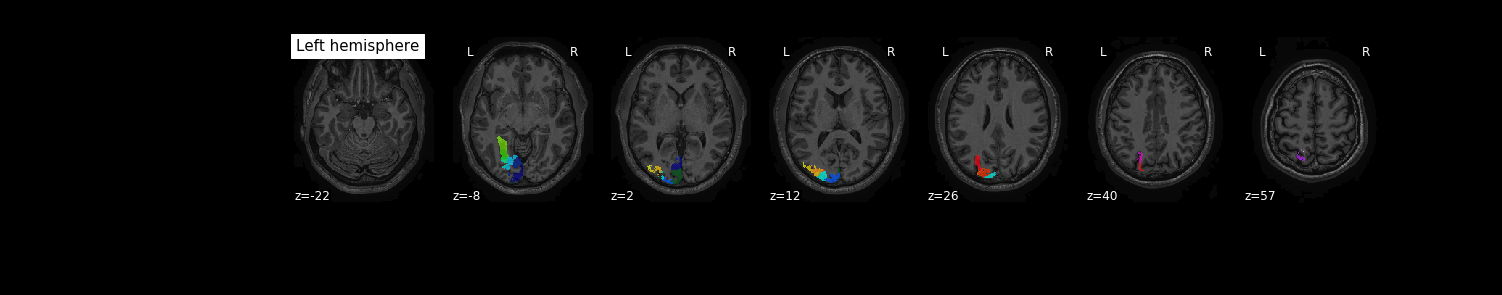

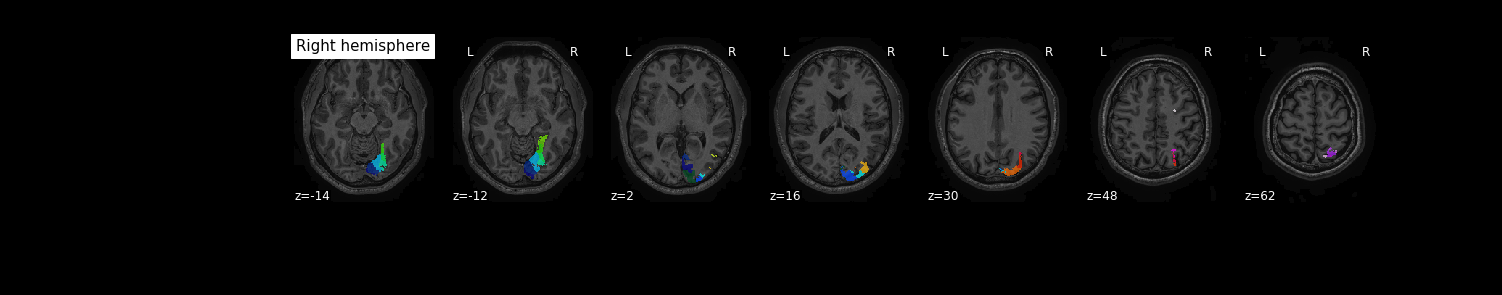

In [85]:
from nilearn.plotting import plot_roi

plot_roi(masknifts[0],anatnift, display_mode='z', cut_coords=7, title="Left hemisphere")
plot_roi(masknifts[1],anatnift, display_mode='z', cut_coords=7, title="Right hemisphere")


I first need to resample these images into the same space as my functional data. (They were registered to a 1mm MNI image).

In [21]:
from nilearn import image

new_imgL = image.resample_to_img(masknifts[0], MERGED_DATA)
new_imgR = image.resample_to_img(masknifts[1], MERGED_DATA)

FNAMEL='/media/nicholas/STORE/probatlas_v4/resampL.nii.gz'
FNAMER='/media/nicholas/STORE/probatlas_v4/resampR.nii.gz'

nb.save(new_imgL,FNAMEL)
nb.save(new_imgR,FNAMER)

Verify that they are indeed now the same shape. 

In [81]:
mask_imgL = nb.load(FNAMEL)
mask_dataL=mask_imgL.get_data()
mask_dataL.shape

(97, 115, 97)

In [82]:
mask_imgR = nb.load(FNAMER)
mask_dataR=mask_imgR.get_data()
mask_dataR.shape

(97, 115, 97)

List the ROI labels.

In [75]:
ROIS=np.unique(mask_dataL)

In [76]:
import pandas as pd

newmaskdir='/media/nicholas/STORE/probatlas_v4/ProbAtlas_v4/newmasks'

LABS='/media/nicholas/STORE/probatlas_v4/ProbAtlas_v4/newmasks/ROI_LABS.csv'
ROI_LABS=pd.read_csv(LABS,sep=",")
ROI_LABS

,ROINAME,
0,NONE,
1,V1v,
2,V1d,
3,V2v,
4,V2d,
5,V3v,
6,V3d,
7,hV4,
8,VO1,
9,VO2,


Now I want to create individual masks for all of these regions. Create a mean image as a reference volume.

In [77]:
from nipype.interfaces import fsl
meanfunc = fsl.ImageMaths()
meanfunc.inputs.op_string='-Tmean'
meanfunc.inputs.suffix='_mean'
meanfunc.inputs.in_file='/media/nicholas/STORE/merge.nii.gz'

meanfunc.inputs.out_file='/media/nicholas/STORE/meanim.nii.gz'


meanfunc.run()

Create the masks

In [ ]:
ref_img = nb.load(meanfunc.inputs.out_file)

masklistL=list()
newmaskniftsL=list()

masklistR=list()
newmaskniftsR=list()

newmaskdir='/media/nicholas/STORE/probatlas_v4/ProbAtlas_v4/newmasks'

i=0
for ROI in ROIS:
    
    masklistL.append((mask_dataL==ROI))
    masklistL[i].astype(int)
    new_imageL=nb.Nifti1Image(masklistL[i].astype(int),ref_img.affine,ref_img.header)
    newmaskniftsL.append(newmaskdir + '/' + ROI_LABS['ROINAME'][i] + '_L.nii.gz')
    nb.save(new_imageL,newmaskniftsL[i])
    
    masklistR.append((mask_dataR==ROI))
    masklistR[i].astype(int)
    new_imageR=nb.Nifti1Image(masklistR[i].astype(int),ref_img.affine,ref_img.header)
    newmaskniftsR.append(newmaskdir + '/' + ROI_LABS['ROINAME'][i] + '_R.nii.gz')
    nb.save(new_imageR,newmaskniftsR[i])
    
    
    i=i+1


In [79]:
firstim=image.index_img(MERGED_DATA, 0)

Plot the voxels contained within the first region.

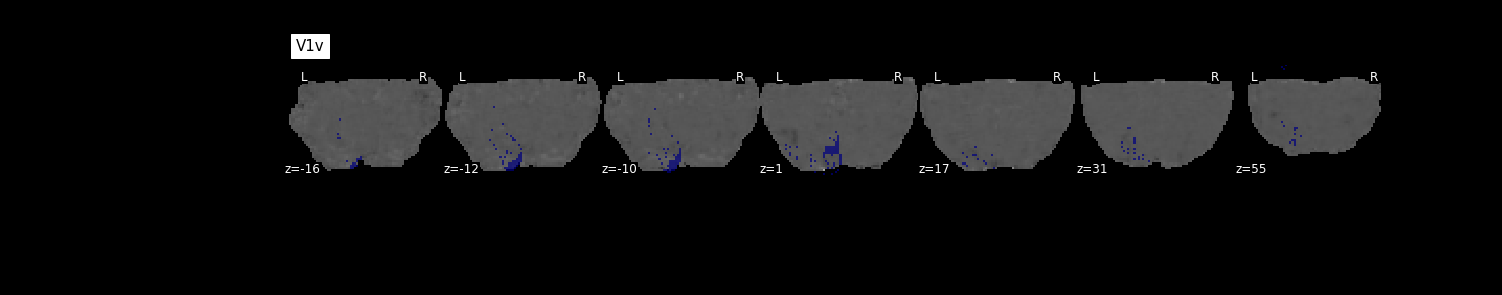

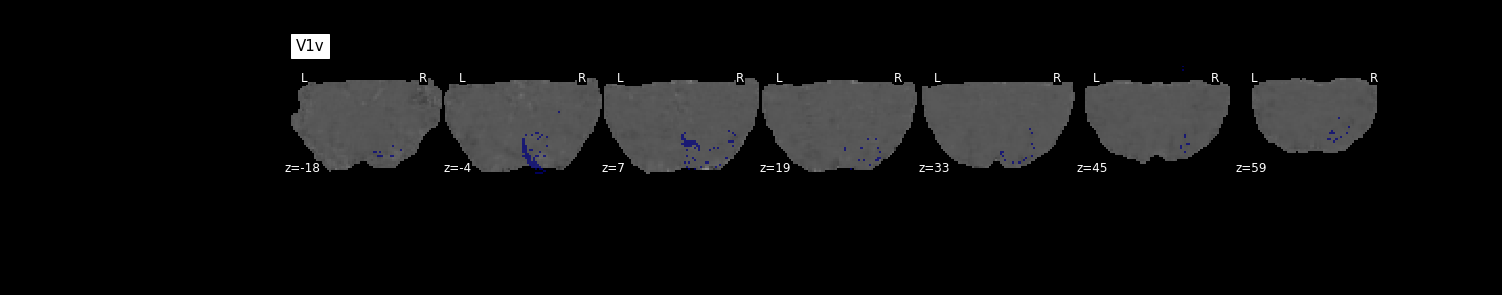

In [80]:
REGION=1

plot_roi(newmaskniftsL[REGION],firstim, display_mode='z', cut_coords=7, title=ROI_LABS['ROINAME'][REGION])
plot_roi(newmaskniftsR[REGION],firstim, display_mode='z', cut_coords=7, title=ROI_LABS['ROINAME'][REGION])

Now, I want to focus on the V1 and V2 regions, as well as some intermediate regions VO1, VO2, LO1, LO2. These have the following indices within my list of masks.

In [87]:
ROIS=(1,2,3,4,8,9,14,15)

Define a function for saving popeye outputs.

In [88]:
dilldumpsdir='/media/nicholas/STORE/dilldump/prf1'

import dill
import os

def dill_save(obj,filename):
    with open(filename,'wb') as output:
        dill.dump(obj,output)

The below will loop though the designated ROIs and save the results into a pickle object. 

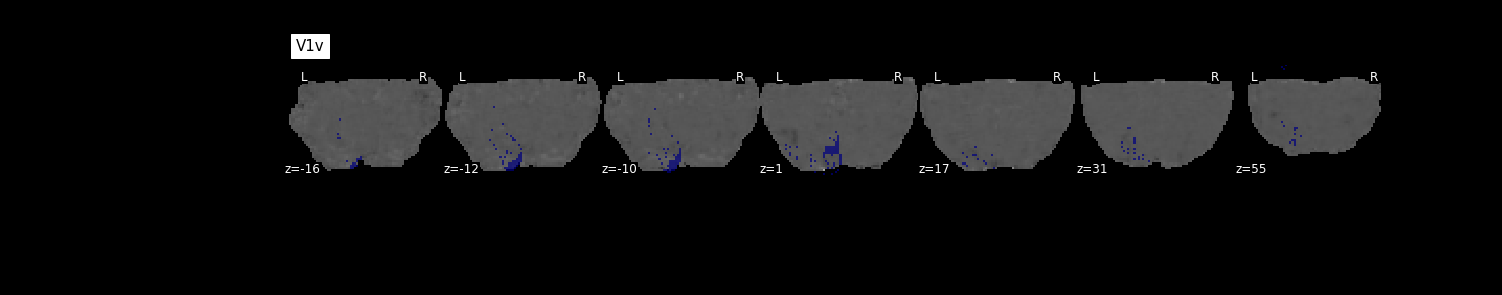

Currently fitting models for region V1vLeft hemisphere
1023 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   51.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  5.5min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 232 tasks      | elapsed:  8.4min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 10.1min
[Parallel(n_jobs=5)]: Done 328 tasks      | elapsed: 11.7min
[Parallel(n_jobs=5)]: Done 382 tasks      | elapsed: 13.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 15.7min
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed: 17.8min
[Parallel(n_jobs=5)]: Done 568 tasks      | elapsed: 20.0min

Saved results for region V1vLeft hemisphere


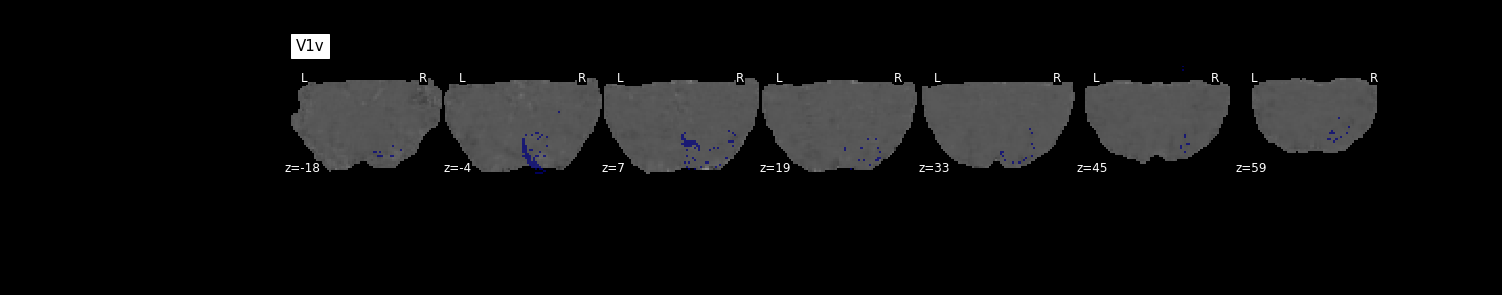

Currently fitting models for region V1vRight hemisphere
957 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   23.6s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.8min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  6.0min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 232 tasks      | elapsed:  8.9min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 10.6min
[Parallel(n_jobs=5)]: Done 328 tasks      | elapsed: 12.3min
[Parallel(n_jobs=5)]: Done 382 tasks      | elapsed: 14.2min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 16.3min
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed: 18.1min
[Parallel(n_jobs=5)]: Done 568 tasks      | elapsed: 20.1min

Saved results for region V1vRight hemisphere


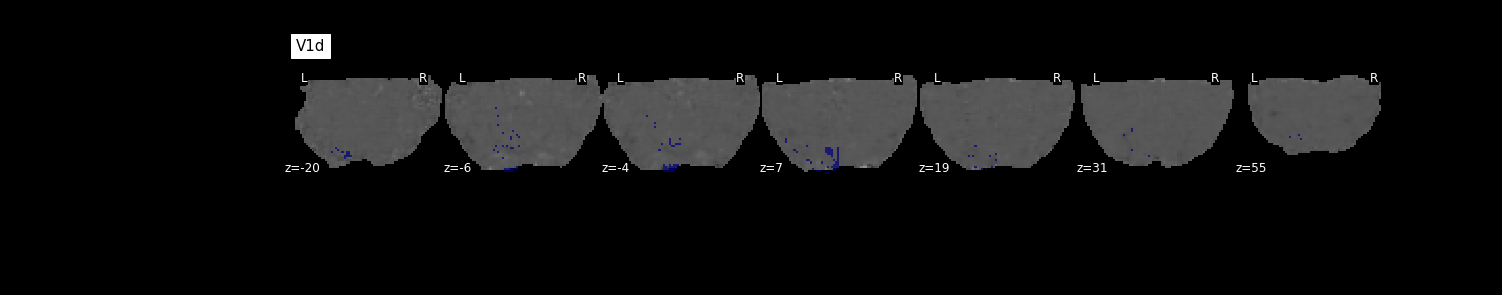

Currently fitting models for region V1dLeft hemisphere
650 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   20.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   58.9s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  5.7min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  6.9min
[Parallel(n_jobs=5)]: Done 232 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:  9.4min
[Parallel(n_jobs=5)]: Done 328 tasks      | elapsed: 11.2min
[Parallel(n_jobs=5)]: Done 382 tasks      | elapsed: 12.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 14.8min
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 568 tasks      | elapsed: 18.9min

Saved results for region V1dLeft hemisphere


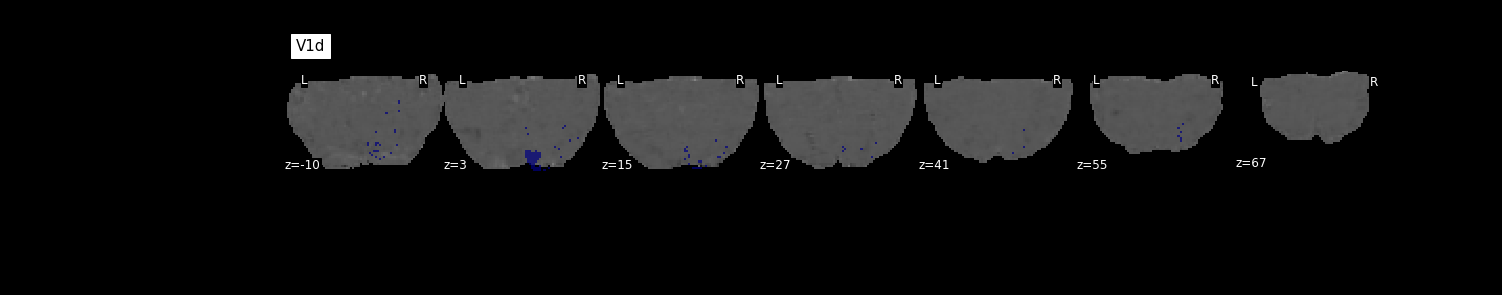

Currently fitting models for region V1dRight hemisphere
645 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   19.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   55.9s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.9min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  6.2min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  7.2min
[Parallel(n_jobs=5)]: Done 232 tasks      | elapsed:  8.4min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 10.1min
[Parallel(n_jobs=5)]: Done 328 tasks      | elapsed: 11.5min
[Parallel(n_jobs=5)]: Done 382 tasks      | elapsed: 13.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed: 16.6min
[Parallel(n_jobs=5)]: Done 568 tasks      | elapsed: 18.6min

Saved results for region V1dRight hemisphere


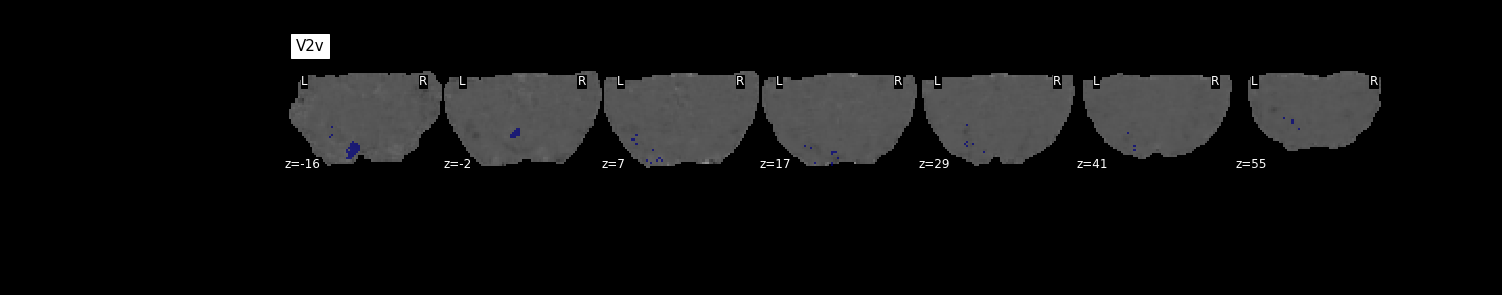

Currently fitting models for region V2vLeft hemisphere
522 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   20.9s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   48.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 232 tasks      | elapsed:  7.9min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:  9.3min
[Parallel(n_jobs=5)]: Done 328 tasks      | elapsed: 11.2min
[Parallel(n_jobs=5)]: Done 382 tasks      | elapsed: 13.2min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 15.2min
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 522 out of 522 | elapsed: 18.2min

Saved results for region V2vLeft hemisphere


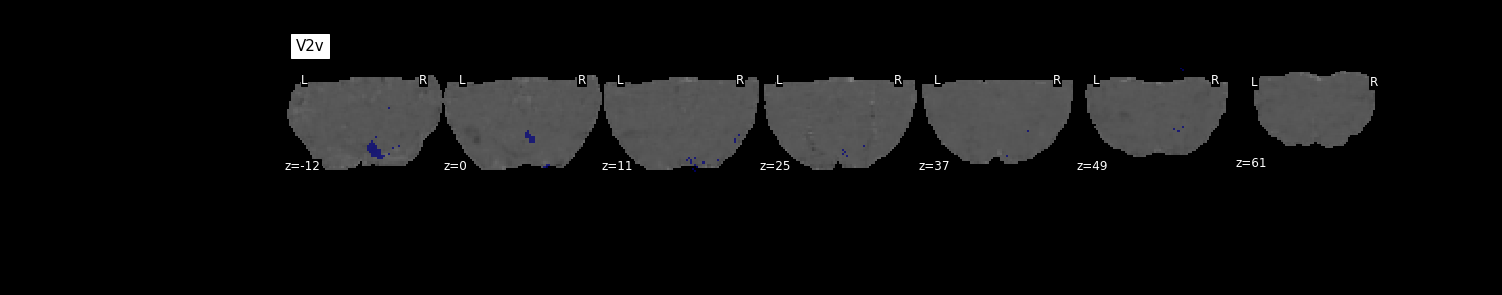

Currently fitting models for region V2vRight hemisphere
519 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   25.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  7.8min
[Parallel(n_jobs=5)]: Done 232 tasks      | elapsed:  9.2min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 10.9min
[Parallel(n_jobs=5)]: Done 328 tasks      | elapsed: 12.8min
[Parallel(n_jobs=5)]: Done 382 tasks      | elapsed: 14.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 16.4min
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed: 18.3min
[Parallel(n_jobs=5)]: Done 519 out of 519 | elapsed: 18.8min

Saved results for region V2vRight hemisphere


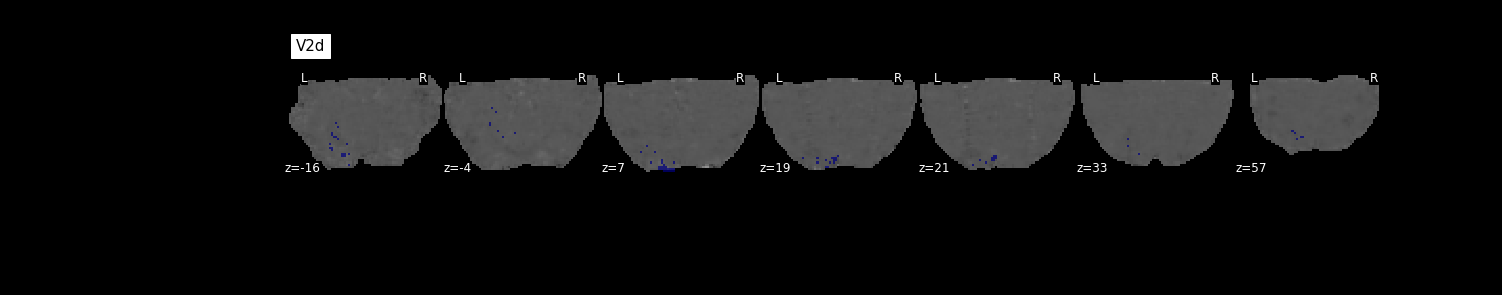

Currently fitting models for region V2dLeft hemisphere
410 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   19.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   52.1s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 232 tasks      | elapsed:  7.6min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:  9.2min
[Parallel(n_jobs=5)]: Done 328 tasks      | elapsed: 10.9min
[Parallel(n_jobs=5)]: Done 382 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 410 out of 410 | elapsed: 13.6min finished


Saved results for region V2dLeft hemisphere


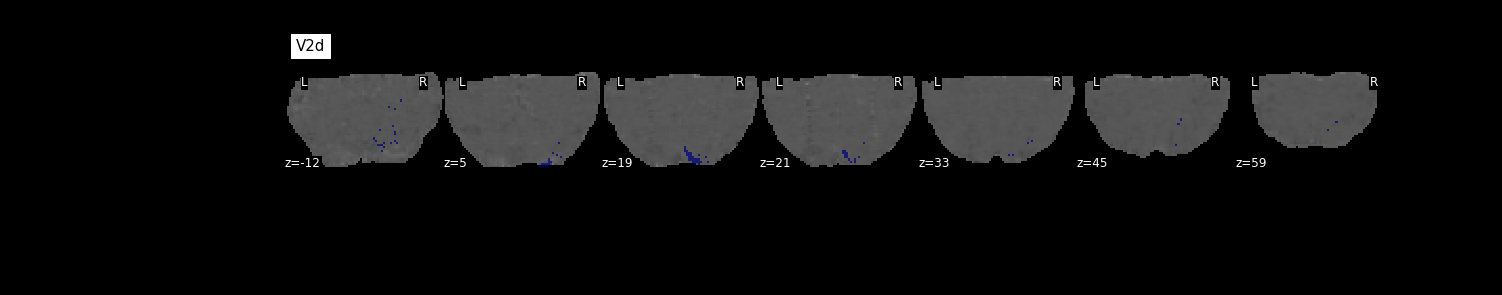

Currently fitting models for region V2dRight hemisphere
411 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   21.8s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   53.7s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.6min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.7min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  7.1min
[Parallel(n_jobs=5)]: Done 232 tasks      | elapsed:  8.3min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:  9.9min
[Parallel(n_jobs=5)]: Done 328 tasks      | elapsed: 11.5min
[Parallel(n_jobs=5)]: Done 382 tasks      | elapsed: 13.1min
[Parallel(n_jobs=5)]: Done 411 out of 411 | elapsed: 14.2min finished


Saved results for region V2dRight hemisphere


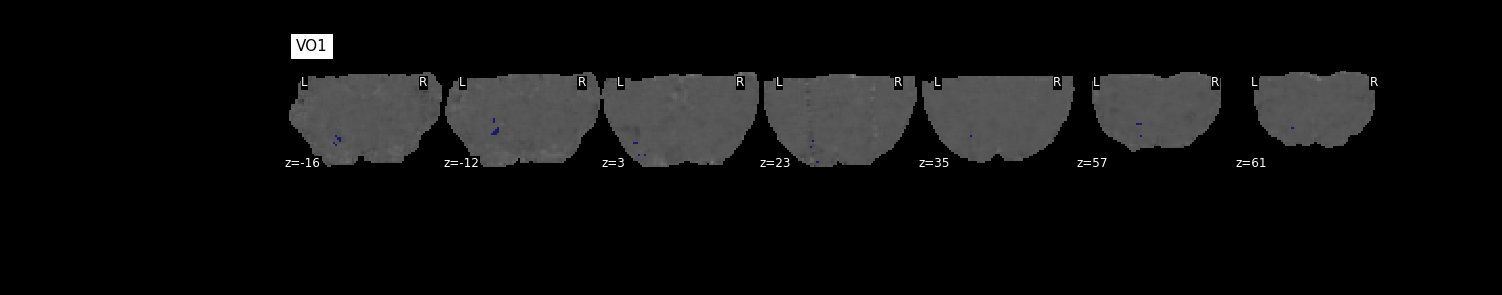

Currently fitting models for region VO1Left hemisphere
151 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   23.0s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   56.8s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.6min
[Parallel(n_jobs=5)]: Done 151 out of 151 | elapsed:  6.0min finished


Saved results for region VO1Left hemisphere


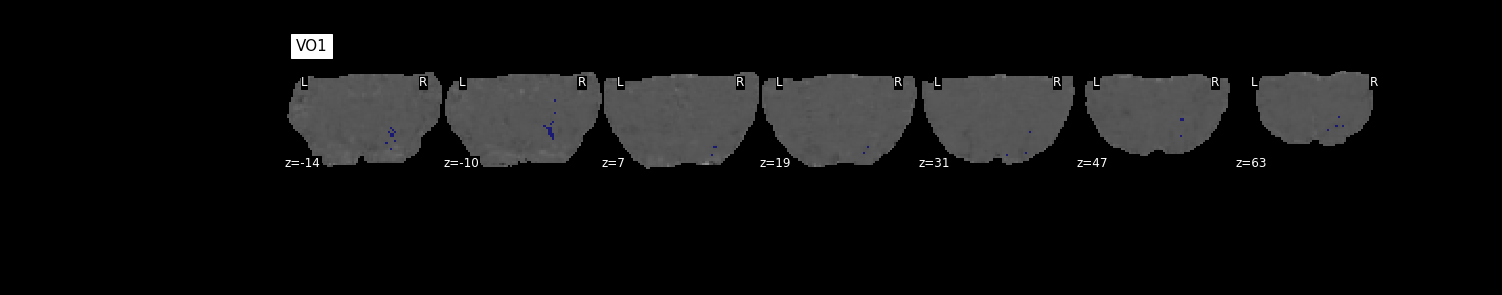

Currently fitting models for region VO1Right hemisphere
159 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   25.6s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   58.3s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 159 out of 159 | elapsed:  5.8min finished


Saved results for region VO1Right hemisphere


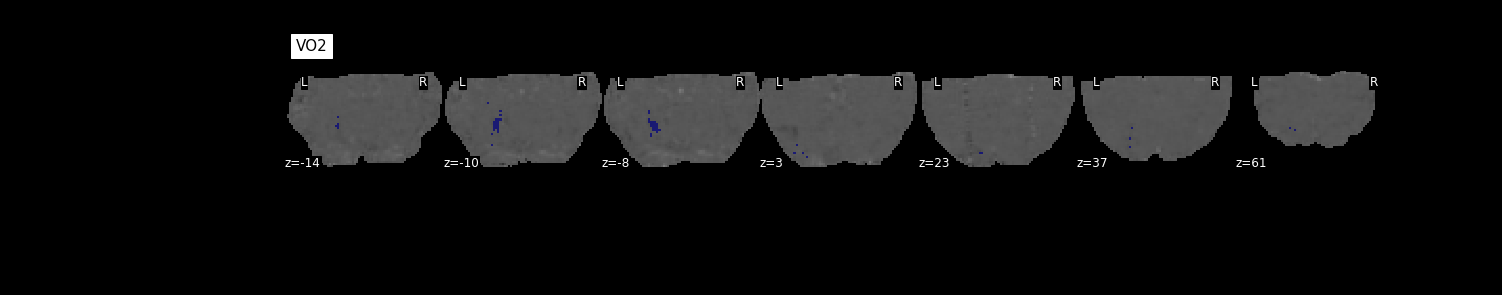

Currently fitting models for region VO2Left hemisphere
161 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   17.3s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   48.5s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  5.7min
[Parallel(n_jobs=5)]: Done 161 out of 161 | elapsed:  6.2min finished


Saved results for region VO2Left hemisphere


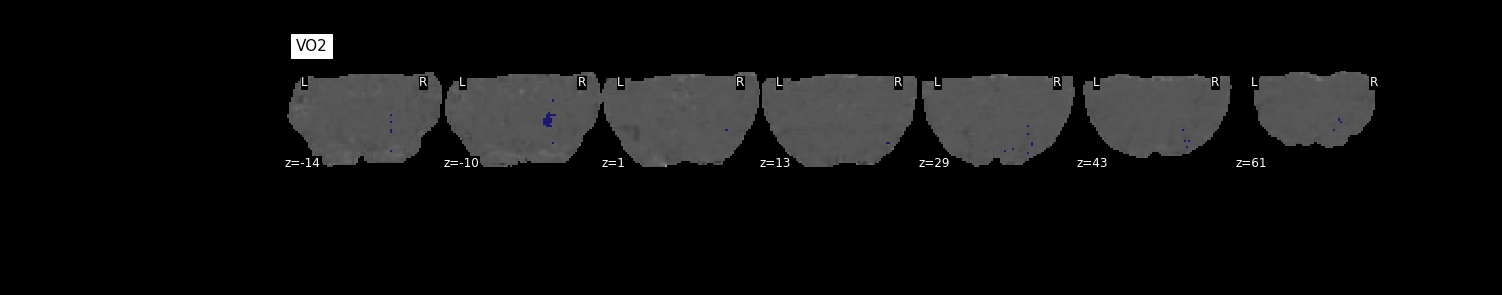

Currently fitting models for region VO2Right hemisphere
151 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   23.4s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   49.6s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.6min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.8min
[Parallel(n_jobs=5)]: Done 151 out of 151 | elapsed:  6.2min finished


Saved results for region VO2Right hemisphere


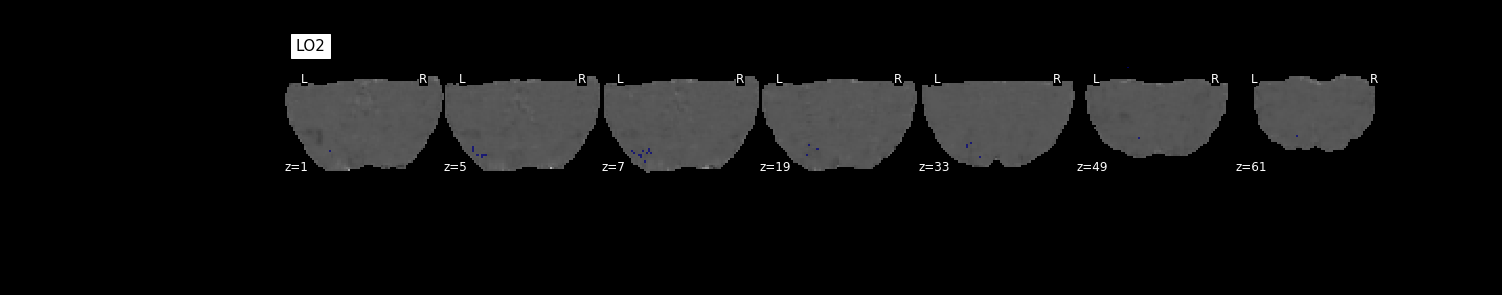

Currently fitting models for region LO2Left hemisphere
88 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   22.5s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   52.8s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done  88 out of  88 | elapsed:  3.5min finished


Saved results for region LO2Left hemisphere


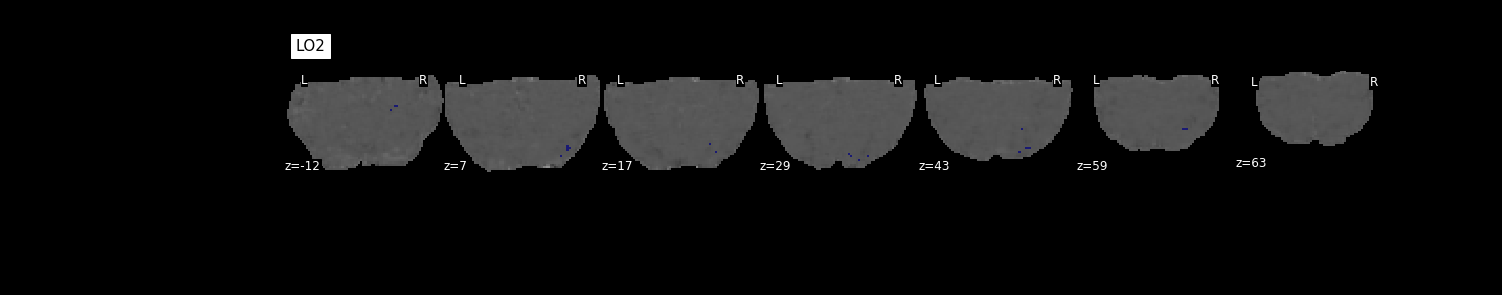

Currently fitting models for region LO2Right hemisphere
98 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   27.8s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done  98 out of  98 | elapsed:  3.8min finished


Saved results for region LO2Right hemisphere


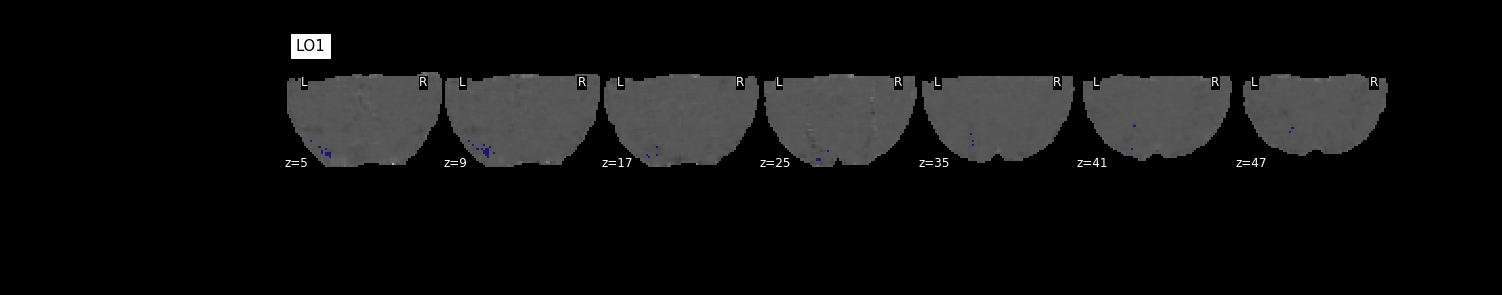

Currently fitting models for region LO1Left hemisphere
124 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   24.3s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   56.4s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 124 out of 124 | elapsed:  4.6min finished


Saved results for region LO1Left hemisphere


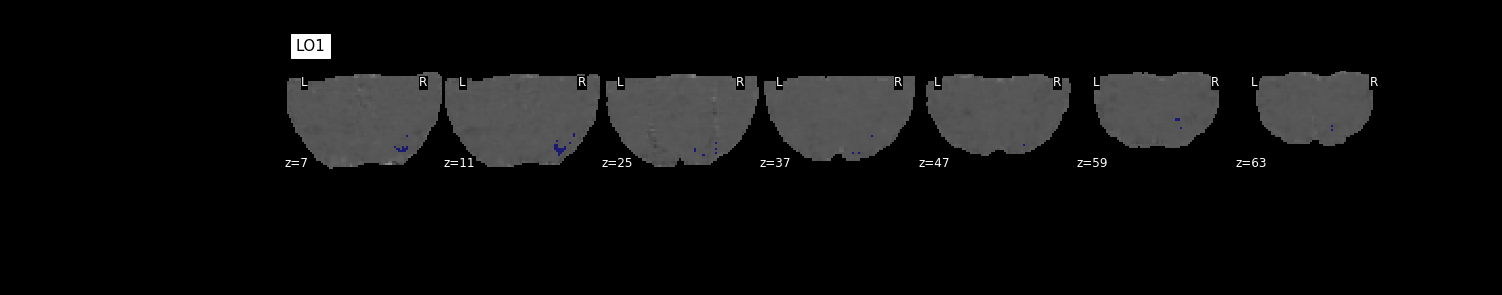

Currently fitting models for region LO1Right hemisphere
142 voxels in region.


[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   29.8s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   58.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done  88 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 142 out of 142 | elapsed:  5.1min finished


Saved results for region LO1Right hemisphere


In [90]:
from joblib import Parallel, delayed


for ROI in ROIS:
    
    #1) Get the indices for voxels where region ROI is the most probable region.

    Lind=np.squeeze(np.where(masklistL[ROI].astype(int)==1))
    Rind=np.squeeze(np.where(masklistR[ROI].astype(int)==1))
    
    # 2) Plot the current ROI
    plot_roi(newmaskniftsL[ROI],firstim, display_mode='z', cut_coords=7, title=ROI_LABS['ROINAME'][ROI])
    plt.show()
    
    print('Currently fitting models for region '+ ROI_LABS['ROINAME'][ROI]+ 'Left hemisphere' )
    print(str(len(Lind[1,:])) + ' voxels in region.')
    
    
    # 3)  Fit the models, using paralell processing. 
    resL=Parallel(n_jobs=5,backend='multiprocessing',verbose=9)(delayed(og.GaussianFit)
    (model,data[Lind[:,vox][0],Lind[:,vox][1],Lind[:,vox][2],:N_TIMEPOINTS],grids,bounds,Ns=grid_size,verbose=0,voxel_index=(Lind[:,vox][0],Lind[:,vox][1],Lind[:,vox][2]))
                                                 for vox in range(len(Lind[1,:])))
    
    # 4) Save the list to a pickle.
    dill_save(resL,os.path.join(dilldumpsdir,ROI_LABS['ROINAME'][ROI]+'_L.pkl'))
    print('Saved results for region '+ ROI_LABS['ROINAME'][ROI] + 'Left hemisphere')

    
    # 5) Repeat for the right hemisphere.
    plot_roi(newmaskniftsR[ROI],firstim, display_mode='z', cut_coords=7, title=ROI_LABS['ROINAME'][ROI])
    plt.show()
    
    print('Currently fitting models for region '+ ROI_LABS['ROINAME'][ROI] + 'Right hemisphere')
    print(str(len(Rind[1,:])) + ' voxels in region.')
    
    resR=Parallel(n_jobs=5,backend='multiprocessing',verbose=9)(delayed(og.GaussianFit)
    (model,data[Rind[:,vox][0],Rind[:,vox][1],Rind[:,vox][2],:N_TIMEPOINTS],grids,bounds,Ns=grid_size,verbose=0,voxel_index=(Rind[:,vox][0],Rind[:,vox][1],Rind[:,vox][2]))
                                                 for vox in range(len(Rind[1,:])))
    
    dill_save(resR,os.path.join(dilldumpsdir,ROI_LABS['ROINAME'][ROI]+'_R.pkl'))
    print('Saved results for region '+ ROI_LABS['ROINAME'][ROI] + 'Right hemisphere')
    
    resL=None
    resR=None
    Lind=None
    Rind=None

Now we have a directory full of pickles that contain model fits for each ROI. 

In [91]:
os.listdir(dilldumpsdir)

['V1d_L.pkl',
 'V1v_L.pkl',
 'VO2_L.pkl',
 'V1v_R.pkl',
 'VO2_R.pkl',
 'LO2_R.pkl',
 'V2v_R.pkl',
 'LO1_R.pkl',
 'LO1_L.pkl',
 'V2d_R.pkl',
 'V2d_L.pkl',
 'V2v_L.pkl',
 'VO1_R.pkl',
 'V1d_R.pkl',
 'VO1_L.pkl',
 'LO2_L.pkl']